Importing Libraries:
librosa: Library for audio processing, used to load audio files and extract features.
numpy: For numerical operations and array handling.
pandas: For data manipulation (though minimally used here).
sklearn: Provides machine learning tools (train-test split, Random Forest, metrics).
os: For navigating the file system to load audio files.

In [2]:
%pip install librosa numpy pandas scikit-learn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 7.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 4.2 MB/s  0:00:06m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [librosa]m7/9 [numba]te]
Note: you may need to restart the kernel to use updated packages.


In [8]:
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import os
import joblib
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# Function to extract audio features from a single file
def extract_features(file_path):
    """
    Extract audio features from an audio file.
    Args:
        file_path (str): Path to the audio file (.wav).
    Returns:
        numpy array: Combined feature vector or None if extraction fails.
    """
    try:
        # Load audio file (GTZAN tracks are 30 seconds)
        y, sr = librosa.load(file_path, duration=30)
        
        # Extract features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1)
        spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr), axis=1)
        tempo = librosa.feature.tempo(y=y, sr=sr)[0]
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        
        # Combine features (13 + 7 + 1 + 12 + 1 = 34 features)
        features = np.concatenate([
            mfcc,
            spectral_contrast,
            [tempo],
            chroma,
            [spectral_centroid]
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [10]:
# Function to load dataset and extract features
def load_data(data_dir, genres):
    """
    Load GTZAN dataset and extract features.
    Args:
        data_dir (str): Path to GTZAN genres directory.
        genres (list): List of genre names.
    Returns:
        X (numpy array): Feature matrix.
        y (numpy array): Genre labels.
    """
    X = []
    y = []
    
    for genre in tqdm(genres, desc="Processing genres"):
        genre_path = os.path.join(data_dir, genre)
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        
        for file_name in tqdm(files, desc=f"Extracting {genre}", leave=False):
            file_path = os.path.join(genre_path, file_name)
            features = extract_features(file_path)
            if features is not None:
                X.append(features)
                y.append(genre)
    
    return np.array(X), np.array(y)

In [11]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, genres, save_path='confusion_matrix.png'):
    """
    Plot and save a confusion matrix.
    """
    cm = confusion_matrix(y_test, y_pred, labels=genres)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved as {save_path}")

In [26]:
# Main function
def main():
    """
    Main function to load GTZAN data, train classifier, and evaluate.
    """
    # Define dataset path and genres
    data_dir = "genres/genres_original"  # Update if different
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    # Load and extract features
    print("Extracting features...")
    X, y = load_data(data_dir, genres)
    print(f"Loaded {len(X)} tracks with {X.shape[1]} features each.")
    
    if len(X) == 0:
        print("No data loaded. Check dataset path and files.")
        return
    
    # Split data (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train Random Forest Classifier
    print("Training classifier...")
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    print("Evaluating classifier...")
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=genres))
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred, genres)
    
    # Save model and scaler
    joblib.dump(clf, 'gtzan_genre_classifier_model.pkl')
    joblib.dump(scaler, 'gtzan_scaler.pkl')
    print("Model and scaler saved.")

In [27]:
# Function to predict genre for a new audio file
def predict_genre(file_path, model_path='gtzan_genre_classifier_model.pkl', scaler_path='gtzan_scaler.pkl'):
    """
    Predict the genre of a new audio file.
    Args:
        file_path (str): Path to the audio file.
        model_path (str): Path to saved model.
        scaler_path (str): Path to saved scaler.
    Returns:
        str: Predicted genre.
    """
    clf = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    features = extract_features(file_path)
    if features is None:
        return "Error: Could not extract features."
    features = scaler.transform([features])
    prediction = clf.predict(features)[0]
    return prediction

Extracting features...


Processing genres:  50%|█████     | 5/10 [02:05<02:00, 24.03s/it]/var/folders/d2/nq0x9cjd54q2hrh6rmmlh6780000gn/T/ipykernel_1907/3542911261.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=30)
/Users/roopaldixit/Library/Python/3.9/lib/python/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing genres/genres_original/jazz/jazz.00054.wav: 


Processing genres: 100%|██████████| 10/10 [04:10<00:00, 25.02s/it]


Loaded 999 tracks with 34 features each.
Training classifier...
Evaluating classifier...
Accuracy: 0.6200

Classification Report:
              precision    recall  f1-score   support

       blues       0.79      0.55      0.65        20
   classical       0.89      0.80      0.84        20
     country       0.46      0.55      0.50        20
       disco       0.52      0.55      0.54        20
      hiphop       0.58      0.55      0.56        20
        jazz       0.63      0.60      0.62        20
       metal       0.77      0.85      0.81        20
         pop       0.58      0.75      0.65        20
      reggae       0.61      0.70      0.65        20
        rock       0.43      0.30      0.35        20

    accuracy                           0.62       200
   macro avg       0.63      0.62      0.62       200
weighted avg       0.63      0.62      0.62       200



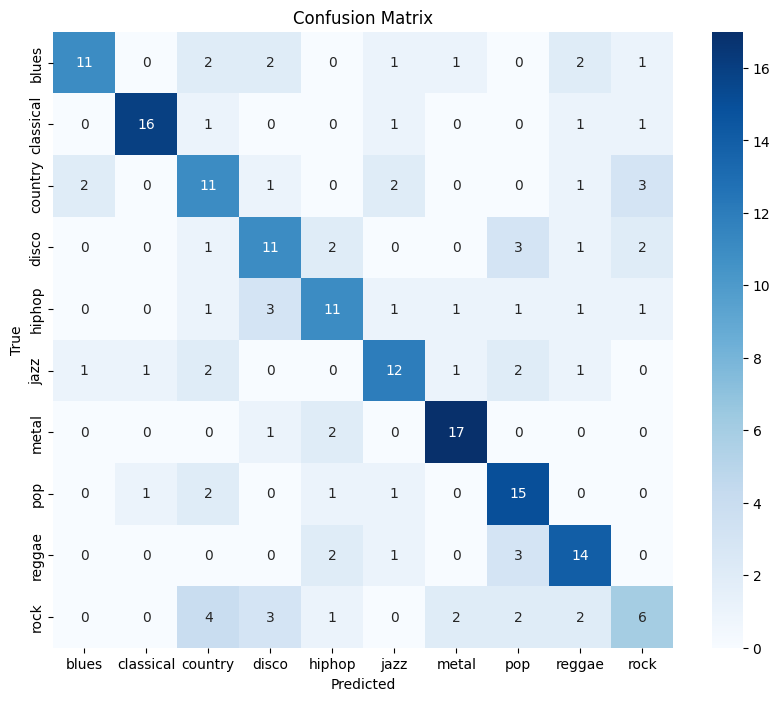

Confusion matrix saved as confusion_matrix.png
Model and scaler saved.


In [28]:
if __name__ == "__main__":
    main()